Investigating using Convolutional Networks on Weak Lensing data
=============

Adapted from 4_conv_WL


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import time
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
from astropy.io import fits
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline
from IPython import display

In [2]:
# Reorganize the code a bit by putting the function definitions first.
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

def getFITS(imagename):
    filename = whereami + '/' + path + imagename
    f = fits.open(filename)
    dataout = f[0].data
    
    return dataout

def read_WL(path,display=None):
    # this is a version to look at sigma8
    labels=['750', '850']
    imgs = np.zeros([2048/degrade, 2048/degrade, nct, len(labels)])
    for j, label in enumerate(labels):
        for i in range(nct):
            filename = whereami + '/' + path + 'smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.'+label+'_4096xy_000'+ np.str(i+1) +'r_0029p_0100z_og.gre.fit'
            if display: print("i: %d  j: %d  name: %s" % (i, j, 'smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.'+label+'_4096xy_000'+ np.str(i+1) +'r_0029p_0100z_og.gre.fit'))
            f = fits.open(filename)
            imgs[:,:,i,j]=rebin(f[0].data, [2048/degrade, 2048/degrade])
            
    return imgs, labels

def slice_data(data, labels, exp_cut, exp_nshift):
    labels=['750', '850']
    # how many panels across
    npanelx = 2**exp_cut
    # and how big are they?
    panelw = 2048/(degrade*npanelx)
    # how many shifted panels?
    nshift = 2**exp_nshift -1
    # and what are the shifts?
    shiftw =  panelw/2**exp_nshift
    # with 4 rotations, and 2 shifts, we have
    imgs = np.zeros([panelw, panelw, nct,(npanelx**2 +(npanelx-1)**2*nshift**2)*8, len(labels)])
    # let's figure out where the centers are, and save that data
    x_centers = np.zeros([nct,(npanelx**2 +(npanelx-1)**2*nshift**2)*8, len(labels)])
    y_centers = np.zeros([nct,(npanelx**2 +(npanelx-1)**2*nshift**2)*8, len(labels)])
    for j, label in enumerate(labels):
        for i in range(nct):
            q=0
            for k in range(npanelx):
                for l in range(npanelx):
                    for r in range(4):
                        imgs[:,:,i,q,j] = np.rot90(data[panelw*k:panelw*(k+1),panelw*l:panelw*(l+1),i, j], r)
                        x_centers[i,q,j] = (panelw*k+panelw*(k+1))/2.
                        y_centers[i,q,j] = (panelw*l+panelw*(l+1))/2.
                        q+=1
                        imgs[:,:,i,q,j] = np.fliplr(np.rot90(data[panelw*k:panelw*(k+1),panelw*l:panelw*(l+1),i, j], r))
                        x_centers[i,q,j] = (panelw*k+panelw*(k+1))/2.
                        y_centers[i,q,j] = (panelw*l+panelw*(l+1))/2.
                        q+=1
            for k in range(npanelx-1):
                for l in range(npanelx-1):
                    for m in range(nshift):
                        for n in range(nshift):
                            for r in range(4):
                                imgs[:,:,i,q,j] = np.rot90(data[panelw*k+m*shiftw:panelw*(k+1)+m*shiftw,panelw*l+n*shiftw:panelw*(l+1)+n*shiftw,i, j], r)
                                x_centers[i,q,j] = (panelw*k+m*shiftw+panelw*(k+1)+m*shiftw)/2.
                                y_centers[i,q,j] = (panelw*l+n*shiftw+panelw*(l+1)+n*shiftw)/2.
                                q+=1
                                imgs[:,:,i,q,j] = np.fliplr(np.rot90(data[panelw*k+m*shiftw:panelw*(k+1)+m*shiftw,panelw*l+n*shiftw:panelw*(l+1)+n*shiftw,i, j], r))
                                x_centers[i,q,j] = (panelw*k+m*shiftw+panelw*(k+1)+m*shiftw)/2.
                                y_centers[i,q,j] = (panelw*l+n*shiftw+panelw*(l+1)+n*shiftw)/2.
                                q+=1
    return imgs, x_centers, y_centers

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [3]:
# Set the paths to the raw data files
#whereami = '/home/jhargis'
whereami = '/Users/jhargis'
path     = 'Dropbox/astroNN/wl_maps/'
#whereami = '/Users/goldston'
#whereami = '/Users/jegpeek'
#path = 'Documents/Weak_Lensing/kmaps_smoothed/'


In [4]:
# Set (1) the factor by which we want to degrade the original WL maps
# and (2) the number of realizations of each universe.
#
#   The original images are 2048 x 2048, and we degrade them using
#   an 8 x 8 sq.pix box, which makes a smaller set of 64 images 
#   (= 256x256 sq.pix in size).

degrade=8
nct = 9

data, labels = read_WL(path,display=True)

print "Data shape :",data.shape
print "Labels     :",labels

i: 0  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0001r_0029p_0100z_og.gre.fit
i: 1  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0002r_0029p_0100z_og.gre.fit
i: 2  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0003r_0029p_0100z_og.gre.fit
i: 3  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0004r_0029p_0100z_og.gre.fit
i: 4  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0005r_0029p_0100z_og.gre.fit
i: 5  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0006r_0029p_0100z_og.gre.fit
i: 6  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0007r_0029p_0100z_og.gre.fit
i: 7  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0008r_0029p_0100z_og.gre.fit
i: 8  j: 0  name: smoothWL-conv_m-512b240_Om0.260_Ol0.74

In [5]:
# Display an example of the full 2048 x 2048 image
#fullimage = getFITS("smoothWL-conv_m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.750_4096xy_0001r_0029p_0100z_og.gre.fit")
#plt.imshow(fullimage, origin="lower")
#plt.colorbar()

In [6]:
# Now compare a small section of the original image to the rebinned version
#   Becaused we used an 8x8 box, a 256x256 region in the original image
#   should correspond to a 32x32 region in the rebinned image
#plt.imshow(fullimage[:256,:256],origin="lower")
#plt.colorbar()
#plt.show()

#image_data = data[:32,:32,0,0]
#image_data.shape
#plt.imshow(image_data, origin='lower')
#plt.colorbar()
#plt.show()

In [7]:
# First we slice the data in the following manner:
#
#   1) Each 256 x 256 image is again split 8 x 8 into 64 images which are 32 x 32 sq. pix in size
#   2) Series of 4 rotations, 2 flips, and shifts of 2 pixels in size
imgs2, x_centers, y_centers = slice_data(data, labels, 3, 3)
img2sh = imgs2.shape

# Next, reshape the arrays and take the first 7 realizations as the training data set
train_dataset = np.transpose(imgs2[:, :, 0:7, :, :].reshape(img2sh[0], img2sh[1], 7.0*img2sh[3]*2.0), (2, 0, 1))
train_xc = x_centers[0:7, :, :].reshape(7.0*img2sh[3]*2.0)
train_yc = y_centers[0:7, :, :].reshape(7.0*img2sh[3]*2.0)
ones = np.ones([7,img2sh[3], 2] )
train_labels = ((np.asarray([0,1])).reshape(1, 1, 2)*ones).reshape(7.0*img2sh[3]*2.0)

# The validation set is the 8th realization
valid_dataset = np.transpose(imgs2[:, :, 7, :, :].reshape(img2sh[0], img2sh[1], 1.0*img2sh[3]*2.0), (2, 0, 1))
valid_xc = x_centers[7, :, :].reshape(1.0*img2sh[3]*2.0)
valid_yc = y_centers[7, :, :].reshape(1.0*img2sh[3]*2.0)
ones = np.ones([1,img2sh[3], 2] )
valid_labels = ((np.asarray([0,1])).reshape(1, 1, 2)*ones).reshape(1.0*img2sh[3]*2.0)

# The test data set is the 9th realization
test_dataset = np.transpose(imgs2[:, :, 8, :, :].reshape(img2sh[0], img2sh[1], 1.0*img2sh[3]*2.0), (2, 0, 1))
test_xc = x_centers[8, :, :].reshape(1.0*img2sh[3]*2.0)
test_yc = y_centers[8, :, :].reshape(1.0*img2sh[3]*2.0)
ones = np.ones([1,img2sh[3], 2] )
test_labels = ((np.asarray([0,1])).reshape(1, 1, 2)*ones).reshape(1.0*img2sh[3]*2.0)


/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer

In [8]:
print "Master images tensor shape:", img2sh
print
print "Train dataset shape:", train_dataset.shape
print "Train labels shape :", train_labels.shape
print "Test dataset shape :", test_dataset.shape
print "Valid dataset shape:", valid_dataset.shape
print "TOTAL data sets    : ", train_dataset.shape[0] + test_dataset.shape[0] + valid_dataset.shape[0]

Master images tensor shape: (32, 32, 9, 19720, 2)

Train dataset shape: (276080, 32, 32)
Train labels shape : (276080,)
Test dataset shape : (39440, 32, 32)
Valid dataset shape: (39440, 32, 32)
TOTAL data sets    :  354960


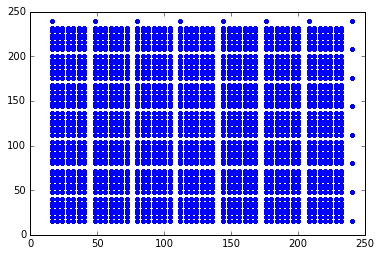

In [9]:
plt.plot(np.reshape(x_centers, 9*19720*2), np.reshape(y_centers, 9*19720*2), '.')

In [10]:
# Just don't even worry about this for now.
# Figure it out later.

"""
#pickle_file = 'notMNIST.pickle'
#pickle_file = '/Users/jegpeek/Documents/WL88.pickle'
pickle_file = '/Users/jegpeek/Dropbox/WL_other.pickle'

usePickle = True

if usePickle:
    with open(pickle_file, 'rb') as f:
      save = pickle.load(f)
      train_dataset = save['train_dataset']
      train_labels = save['train_labels']
      valid_dataset = save['valid_dataset']
      valid_labels = save['valid_labels']
      test_dataset = save['test_dataset']
      test_labels = save['test_labels']
      del save  # hint to help gc free up memory
      print('Training set', train_dataset.shape, train_labels.shape)
      print('Validation set', valid_dataset.shape, valid_labels.shape)
      print('Test set', test_dataset.shape, test_labels.shape)
else:
    %run Read_WL.py
"""

"\n#pickle_file = 'notMNIST.pickle'\n#pickle_file = '/Users/jegpeek/Documents/WL88.pickle'\npickle_file = '/Users/jegpeek/Dropbox/WL_other.pickle'\n\nusePickle = True\n\nif usePickle:\n    with open(pickle_file, 'rb') as f:\n      save = pickle.load(f)\n      train_dataset = save['train_dataset']\n      train_labels = save['train_labels']\n      valid_dataset = save['valid_dataset']\n      valid_labels = save['valid_labels']\n      test_dataset = save['test_dataset']\n      test_labels = save['test_labels']\n      del save  # hint to help gc free up memory\n      print('Training set', train_dataset.shape, train_labels.shape)\n      print('Validation set', valid_dataset.shape, valid_labels.shape)\n      print('Test set', test_dataset.shape, test_labels.shape)\nelse:\n    %run Read_WL.py\n"

In [11]:
# Reformat into a TensorFlow-friendly shape:
# - convolutions need the image data formatted as a cube (width by height by #channels)
# - labels as float 1-hot encodings.

image_size = 32
num_labels = 2
num_channels = 1 # grayscale

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (276080, 32, 32, 1), (276080, 2))
('Validation set', (39440, 32, 32, 1), (39440, 2))
('Test set', (39440, 32, 32, 1), (39440, 2))


In [12]:
# Cut this down to a subset
test_frac = 0.3
_train_dataset = train_dataset[0:train_dataset.shape[0]*test_frac,:,:,:]
_train_labels  = train_labels[0:train_labels.shape[0]*test_frac,:]
_test_dataset = test_dataset[0:test_dataset.shape[0]*test_frac,:,:,:]
_test_labels  = test_labels[0:test_labels.shape[0]*test_frac,:]
_valid_dataset = valid_dataset[0:valid_dataset.shape[0]*test_frac,:,:,:]
_valid_labels  = valid_labels[0:valid_labels.shape[0]*test_frac,:]
print('--> Using subset <--')
#print('Training set', _train_dataset.shape, _train_labels.shape)
#print('Validation set', _valid_dataset.shape, _valid_labels.shape)
#print('Test set', _test_dataset.shape, _test_labels.shape)
train_dataset = _train_dataset
train_labels = _train_labels
test_dataset = _test_dataset
test_labels = _test_labels
valid_dataset = _valid_dataset
valid_labels = _valid_labels
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

--> Using subset <--
('Training set', (82824, 32, 32, 1), (82824, 2))
('Validation set', (11832, 32, 32, 1), (11832, 2))
('Test set', (11832, 32, 32, 1), (11832, 2))


/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jhargis/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer numb

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [13]:
batch_size = 128  # 16
patch_size = 5    # 5
depth = 32        # 16
depth2= 64        # JRH addition
num_hidden = 2048   # 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Global Step
    #global_step = tf.Variable(1.)
    #learn_decay = 0.85
    #learning_rate = tf.train.exponential_decay(0.005, global_step, 10000, learn_decay, staircase=True)
    learning_rate = 0.01

    # Variables.
    #layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    #layer1_biases = tf.Variable(tf.zeros([depth]))
    #layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    #layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    #layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    #layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    #layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    #layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Alternate variable setup
    #   Layer 1: Compute 16 features = depth
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    #layer1_biases = tf.Variable(tf.zeros([depth]))
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]))
    
    #   Layer 2: Compute 32 features = DEPTH2
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth2], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]))
    
    #   Layer 3: Fully-connected layer should use depth2, which results from layer2
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth2, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(0.01, shape=[num_hidden]))
    
    #   Layer 4: Readout layer
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(0.01, shape=[num_labels]))

    keep_prob = tf.placeholder(tf.float32)
    
    #with tf.name_scope('derp'):
    #  spl = tf.split(3, 16, layer1_weights)
    #  filter_summary = tf.image_summary((spl[0]).name, spl[0], max_images=1)

    # Model.
    def model(data):
        #  Layer 1
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        #  Layer 2
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        #  Layer 3 = fully connected
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        #  Layer 4 = readout layer
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
    def variable_summaries(var, name):
        with tf.name_scope("summaries"):
            mean = tf.reduce_mean(var)
            tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.scalar_summary('sttdev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)
        
    with tf.name_scope('layer1'):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope("weights"):
            variable_summaries(layer1_weights, 'layer1/weights')
            with tf.name_scope("images"):
                spl = tf.split(3, 8, layer1_weights)
                tf.image_summary("layer1/weights", spl[0])
        with tf.name_scope("biases"):
            variable_summaries(layer1_biases, 'layer1/biases')

    with tf.name_scope('layer2'):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope("weights"):
            variable_summaries(layer2_weights, 'layer2/weights')
            with tf.name_scope("images"):
                spl = tf.split(3, 16, layer2_weights)
                tf.image_summary("layer2/weights", spl[0])
        with tf.name_scope("biases"):
            variable_summaries(layer2_biases, 'layer2/biases')

    with tf.name_scope('layer3'):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope("weights"):
            variable_summaries(layer2_weights, 'layer3/weights')
        with tf.name_scope("biases"):
            variable_summaries(layer3_biases, 'layer3/biases')
            
    with tf.name_scope('layer4'):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope("weights"):
            variable_summaries(layer4_weights, 'layer4/weights')
        with tf.name_scope("biases"):
            variable_summaries(layer4_biases, 'layer4/biases')
            
                
    with tf.name_scope('loss'):
        # Try to log the loss
        tf.scalar_summary('loss', loss)
        
    with tf.name_scope('learning_rate'):
        tf.scalar_summary('learning_rate', learning_rate)
                
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

    merged = tf.merge_all_summaries()

In [14]:
permutation = np.random.permutation(train_labels.shape[0])
train_dataset = train_dataset[permutation,:,:]
train_labels = train_labels[permutation]

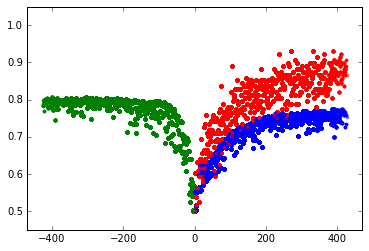

Minibatch loss at step 85200: 0.296308 (0.149 sec)


KeyboardInterrupt: 

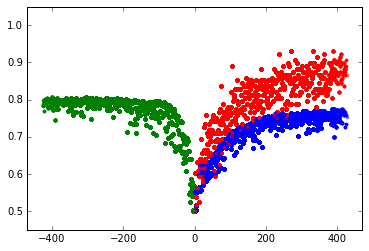

In [15]:
# Run of TensorFlow without the permutations
# but with the TensorBoard logging calls
num_steps = 200001
print_step = 200
summary_step = 200
losses = np.zeros((num_steps-1)/print_step+1)
acc_valid = np.zeros((num_steps-1)/print_step+1)
acc_test = np.zeros((num_steps-1)/print_step+1)
acc_train = np.zeros((num_steps-1)/print_step+1)
q = 0
p = 0

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    summary_writer = tf.train.SummaryWriter(whereami+'/Documents/logs', session.graph_def)
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        start_time = time.time()
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        summary, _, l, predictions = session.run([merged, optimizer, loss, train_prediction], feed_dict=feed_dict)
        duration = time.time() - start_time
        if (step % print_step == 0):
            losses[q] = l
            acc_valid[q] = accuracy(valid_prediction.eval(), valid_labels)/100.0
            acc_test[q] = accuracy(test_prediction.eval(), test_labels)/100.0
            acc_train[q] = accuracy(predictions, batch_labels)/100.0
            q += 1
            plt.plot(np.arange(0,(num_steps-1)/print_step+1), acc_valid, '.', color='b',alpha=0.5)
            plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),acc_test, '.', color='g',alpha=0.5)
            plt.plot(np.arange(0,(num_steps-1)/print_step+1), acc_train, '.', color='r',alpha=0.5)
            plt.ylim([0.45, 1.05])
            #plt.xlim([-1000, 1000])
            plt.xlim([-1*((step/print_step)*1.1),(step/print_step)*1.1])
            #plt.xlim([-1*(((num_steps-1)/print_step+1)*1.1),((num_steps-1)/print_step+1)*1.1])
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print('Minibatch loss at step %d: %f (%.3f sec)' % (step, l, duration))
            #print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        if (step % summary_step == 0):
            #print "got here"
            summary_writer.add_summary(summary, p)
            p += 1
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

In [ ]:
# permutation = np.random.permutation(train_labels.shape[0])
#train_dataset = train_dataset[permutation,:,:]
#train_labels = train_labels[permutation]

num_steps = 20001
print_step = 200
losses = np.zeros((num_steps-1)/print_step+1)
acc_valid = np.zeros((num_steps-1)/print_step+1)
acc_test = np.zeros((num_steps-1)/print_step+1)
q = 0
p=0

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % print_step == 0):
            losses[q] = l
            acc_valid[q] = accuracy(valid_prediction.eval(), valid_labels)/100.0
            acc_test[q] = accuracy(test_prediction.eval(), test_labels)/100.0
            q += 1
            plt.plot(np.arange(0,(num_steps-1)/print_step+1), acc_valid, '.', color='b')
            plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),acc_test, '.', color='g')
            plt.ylim([0.45, 0.65])
            plt.xlim([-1000, 1000])
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

plt.plot(np.arange(0,(num_steps-1)/print_step+1), acc_valid, '.', color='b')
plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),acc_test, '.', color='g')
plt.ylim([0.45, 0.75])
plt.xlim([-100, 100])

In [ ]:
plt.plot(acc_test, acc_valid, '.', color='b')
#plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),losses, '.', color='g')
plt.ylim([0.4, 0.7])
plt.xlim([0.0, 1.0])

**Open questions:**
+ Why is there so much scatter in the loss function over time?
+ Is there structure in the loss function over time?
+ If I plot loss vs. accuracy, what do I get? 
+ Do I really see a difference when I scramble vs. leave in order, and if so, is it because of the way SGD interacts with the two cosmologies?
+ will deeper / better networks get us over 65%?
+ Why, oh why, are my test and valid data sets so damn well correlated??

graph.get_tensor_by_name.im_func

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---